In [1]:
import sys
sys.path.insert(1, "../../")

import utils
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler

# Deep learning import
import tensorflow as tf

# Evaluation Imports
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# Disable GPU
# tf.config.set_visible_devices([], 'GPU')
plt.style.use('default')

In [3]:
# Configurations
isDemoMode = False
DATA_FILE_NAME = '../../Data/final_crypto_data.csv'
SELECTED_MONTHS = [10,11,12,1,2,3]

# Define Helper functions
- split_sequence: This function is used to split a univariate time series into sequences consist of n steps.
 Steps are given by user. For example in our case it would be 60 steps (for 60 minutes lag.)

In [4]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def train_test_valid_split(total_x, total_y, train_size=0.9, valid_size=0.1) :
    train_index = int(len(total_x) * train_size)
    valid_index = int(len(total_x) * valid_size)

    X_train, y_train = total_x[0 :train_index], total_y[0 :train_index]
    X_valid, y_valid = total_x[train_index :train_index + valid_index], total_y[train_index :train_index + valid_index]
    X_test, y_test = total_x[train_index + valid_index :], total_y[train_index + valid_index :]

    print("-------- train test valid split --------")
    print(len(X_train)), print(len(y_train))
    print(len(X_valid)), print(len(y_valid))
    print(len(X_test)), print(len(y_test))
    print("----------------------------------------")

    return np.array(X_train), \
           np.array(y_train), \
           np.array(X_valid), \
           np.array(y_valid), \
           np.array(X_test), \
           np.array(y_test)

def display_training_curves(training, validation, title, subplot=None) :
    if subplot is not None:
        ax = plt.subplot(subplot)
    else:
        ax = plt.subplot()
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])
    plt.show()
    return


 ### Update Default number of DF columns

In [5]:
print(f"Default number of DF columns displayed {pd.get_option('display.max_columns')}")

# settings to display all columns
pd.set_option("display.max_columns", None)

Default number of DF columns displayed 20


# Load Test data from CSV

In [6]:
df = pd.read_csv (DATA_FILE_NAME)
df = utils.setDateTimeAsIndex(df)
df = utils.filterInMonths(df, SELECTED_MONTHS)
df

,Unnamed: 0,_id,high_24h,last_24h,bid_24h,vwap_24h,volume_24h,low_24h,ask_24h,open_24h,high_1min,volume_1min,low_1min,close_1min,open_1min,max_supply,circulating_supply,total_supply,quote_USD_price,quote_volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,reddit_compound_polarity
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-29 17:09:28,0,627127fabbd592fa2c7f25a9,62971.54,62561.13,62559.74,60908.08,5113.537402,56425.0,62561.13,60608.95,62565.90,1.425169,62539.20,62561.86,62545.45,21000000.0,18858012.0,18858012.0,62556.005047,4.304916e+10,6.0514,-0.314446,2.307206,2.108769,26.873643,29.933036,49.972913,1.179682e+12,43.4826,1.313676e+12,0.000834
2021-10-29 17:08:29,1,627127fabbd592fa2c7f25aa,62971.54,62580.05,62571.40,60907.24,5111.938615,56425.0,62580.05,60608.95,62580.05,0.046548,62555.88,62577.47,62555.88,21000000.0,18858012.0,18858012.0,62530.948307,4.305221e+10,6.0179,-0.422853,2.137546,2.146984,26.873643,29.917416,49.972913,1.179209e+12,43.4826,1.313150e+12,0.000834
2021-10-29 17:10:28,2,627127fabbd592fa2c7f25ab,62971.54,62591.17,62582.19,60908.89,5115.569587,56425.0,62596.03,60608.95,62597.65,2.112533,62555.02,62597.64,62560.95,21000000.0,18858012.0,18858012.0,62551.924819,4.304739e+10,6.0643,-0.365020,2.383982,2.150485,26.873643,29.997052,49.972913,1.179605e+12,43.4826,1.313590e+12,0.000834
2021-10-29 17:14:32,3,627127fabbd592fa2c7f25ac,62971.54,62590.43,62572.06,60909.91,5117.061581,56425.0,62590.43,60608.95,62615.00,0.596406,62590.43,62590.43,62603.62,21000000.0,18858012.0,18858012.0,62591.537709,4.311295e+10,6.1673,-0.311393,2.375399,2.464668,26.873643,30.044297,49.972913,1.180352e+12,43.4826,1.314422e+12,0.000834
2021-10-29 17:12:31,4,627127fabbd592fa2c7f25ad,62971.54,62600.43,62587.09,60909.54,5117.193435,56425.0,62606.26,60608.95,62600.43,0.657752,62577.18,62600.43,62577.18,21000000.0,18858012.0,18858012.0,62584.316178,4.310036e+10,6.1706,-0.379612,2.422122,2.443523,26.873643,30.074340,49.972913,1.180216e+12,43.4826,1.314271e+12,0.000834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-29 15:03:51,206562,627127ffbbd592fa2c824c8b,48234.00,47841.78,47821.47,47686.37,2055.574837,46897.0,47841.83,47152.38,47841.78,0.032706,47779.93,47841.78,47787.41,21000000.0,18997287.0,18997287.0,47796.800709,3.593814e+10,-11.6642,0.220574,0.405000,11.727515,23.065838,29.951735,-0.127362,9.080095e+11,41.9541,1.003733e+12,-0.260219
2022-03-29 15:02:51,206563,627127ffbbd592fa2c824c8c,48234.00,47817.06,47781.38,47686.37,2055.589733,46897.0,47804.30,47152.38,47839.85,1.175399,47817.06,47817.06,47823.15,21000000.0,18997287.0,18997287.0,47796.800709,3.593814e+10,-11.6642,0.220574,0.405000,11.727515,23.065838,29.951735,-0.127362,9.080095e+11,41.9541,1.003733e+12,-0.329272
2022-03-29 15:04:51,206564,627127ffbbd592fa2c824c8d,48234.00,47839.81,47813.47,47686.46,2054.541798,46897.0,47834.63,47152.38,47842.74,0.016080,47839.81,47839.81,47842.74,21000000.0,18997287.0,18997287.0,47758.428512,3.581643e+10,-11.9431,0.088208,0.447990,11.702487,23.073256,29.909264,-0.197507,9.072806e+11,41.9258,1.002927e+12,-0.260219


# Print the number of Dataset observations.


In [7]:
len(df)

206567

# Plot Last minute Close price

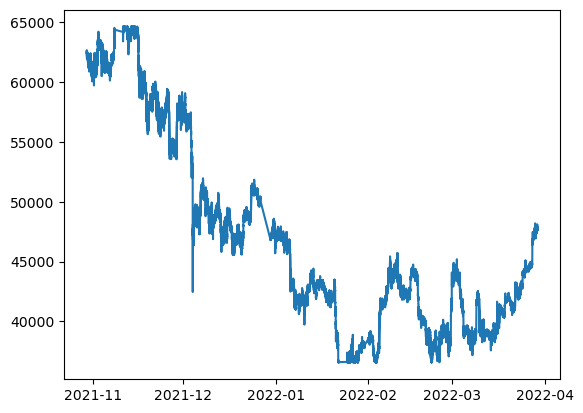

In [8]:
plt.plot(df.index, df['close_1min'] )
plt.show()

## Data Preprocessing
- Scale Data
- Get total_x and total_y based on prediction days
- convert them in np arrays
- reshape total_x

In [9]:
test_df = df.tail(round(0.10 * len(df))) if isDemoMode else df

# scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(test_df["close_1min"].values.reshape(-1,1))
scaled_data

array([[0.92534543],
       [0.92590113],
       [0.92661915],
       ...,
       [0.40126083],
       [0.40171329],
       [0.40194148]])

# Bitcont Price Predicition Preperations

Gia na pragmatopoisoume provlepsi tis timis tou bitcoin tha xtrisimopoiisoume tin timi **`close_1min`** prokoimenou na
provlepsoume me tin timi me tin opoia tha klisi to BTC sto epomeno lepto.

Gia na ekpedeusoume kai na dokimasoume ta montela mas tha xorisoume to dataset mas se 2 yposinola
- train_set: to opoio tha periexei to 90% ton paratirisewn
- test_set: to opoio tha periexei to 10% ton paratirisewn.

In [10]:
n_steps = 15
X, y = split_sequence(scaled_data, n_steps)

print(f"Split Dataset X length: {len(X)}")
print(f"Split Dataset y length: {len(y)}")

Split Dataset X length: 206552
Split Dataset y length: 206552


# Create Vanilla LSTM

A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.

- Dilonoume Sto LSTM to shape pou tha exoun ta inputs tou.
- Epidi provlepoume univariate series exoume panta 1 xaraktiristiko gia kathe paratirisi. (px lepto sto BTC) ara ***`n_features = 1`***
- opote to LSTM input shape prepei na einai (n_steps, n_features) opou n_steps to noumero ton lags pou orisame sto Data preprocessing.
- Opote prepei na metasximatisoume ta dedomena mas apo ena 2D array se ena 3D array opou
    - 1st D => to plithos ton paratiriseon (gia tis opoies ipaexoun n_step proigoumenes paratirisis)
    - 2nd D => oso einai to plithos twn lags pou epileksame (n_step)
    - 3ed D => to plithos ton xaraktiristikon (univariate = 1)

In [11]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[0.92534543],
        [0.92590113],
        [0.92661915],
        ...,
        [0.92404395],
        [0.92799575],
        [0.92752051]],

       [[0.92590113],
        [0.92661915],
        [0.92636248],
        ...,
        [0.92799575],
        [0.92752051],
        [0.92426181]],

       [[0.92661915],
        [0.92636248],
        [0.92671847],
        ...,
        [0.92752051],
        [0.92426181],
        [0.92780067]],

       ...,

       [[0.40043566],
        [0.4025018 ],
        [0.40158051],
        ...,
        [0.4014908 ],
        [0.40133096],
        [0.40045096]],

       [[0.4025018 ],
        [0.40158051],
        [0.40163604],
        ...,
        [0.40133096],
        [0.40045096],
        [0.40126083]],

       [[0.40158051],
        [0.40163604],
        [0.4017528 ],
        ...,
        [0.40045096],
        [0.40126083],
        [0.40171329]]])

Train test split

In [12]:
train_X, train_y, valid_X, valid_y, test_X, test_y = utils.train_test_valid_split(
        X,
        y,
        train_size=0.8,
        valid_size=0.1
    )
print("----------------------------")
print(f"-------- Train X: {train_X.shape}, Train y: {train_y.shape} --------")
print(f"-------- Valid X: {valid_X.shape}, Valid y: {valid_y.shape} --------")
print(f"-------- Test X: {test_X.shape}, Test y: {test_y.shape} --------")
print("----------------------------\n")

-------- train test valid split --------
165241
165241
20655
20655
20656
20656
----------------------------------------
----------------------------
-------- Train X: (165241, 15, 1), Train y: (165241, 1) --------
-------- Valid X: (20655, 15, 1), Valid y: (20655, 1) --------
-------- Test X: (20656, 15, 1), Test y: (20656, 1) --------
----------------------------



In [13]:
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(
    64,
    # activation='relu',
    # unroll=True,
    input_shape=(n_steps, n_features)
))
# model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0012) , loss='mse')

Metal device set to: Apple M1 Pro


2023-01-22 13:25:08.468248: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-22 13:25:08.468371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
# fit model
history = model.fit(
    X,
    y,
    epochs=50,
    verbose=2,
    batch_size=512,
    validation_data=(valid_X, valid_y),
    shuffle=False,
)

2023-01-22 13:25:08.672311: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2023-01-22 13:25:09.368416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 13:25:09.469903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 13:25:09.568939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 13:25:14.510978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 13:25:14.551065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


404/404 - 6s - loss: 0.0091 - val_loss: 0.0016 - 6s/epoch - 15ms/step
Epoch 2/50
404/404 - 5s - loss: 2.9993e-04 - val_loss: 6.7309e-04 - 5s/epoch - 12ms/step
Epoch 3/50
404/404 - 5s - loss: 1.4194e-04 - val_loss: 2.0881e-04 - 5s/epoch - 12ms/step
Epoch 4/50
404/404 - 5s - loss: 6.3429e-05 - val_loss: 5.9299e-05 - 5s/epoch - 12ms/step
Epoch 5/50
404/404 - 5s - loss: 3.5408e-05 - val_loss: 1.2734e-05 - 5s/epoch - 12ms/step
Epoch 6/50
404/404 - 5s - loss: 3.0005e-05 - val_loss: 1.8074e-05 - 5s/epoch - 12ms/step
Epoch 7/50
404/404 - 5s - loss: 3.4899e-05 - val_loss: 9.2788e-05 - 5s/epoch - 13ms/step
Epoch 8/50
404/404 - 5s - loss: 6.9659e-05 - val_loss: 5.7163e-04 - 5s/epoch - 12ms/step
Epoch 9/50
404/404 - 5s - loss: 3.1008e-04 - val_loss: 0.0027 - 5s/epoch - 13ms/step
Epoch 10/50
404/404 - 5s - loss: 5.0912e-04 - val_loss: 0.0026 - 5s/epoch - 12ms/step
Epoch 11/50
404/404 - 5s - loss: 6.0710e-04 - val_loss: 0.0025 - 5s/epoch - 13ms/step
Epoch 12/50
404/404 - 5s - loss: 6.6631e-04 - val_

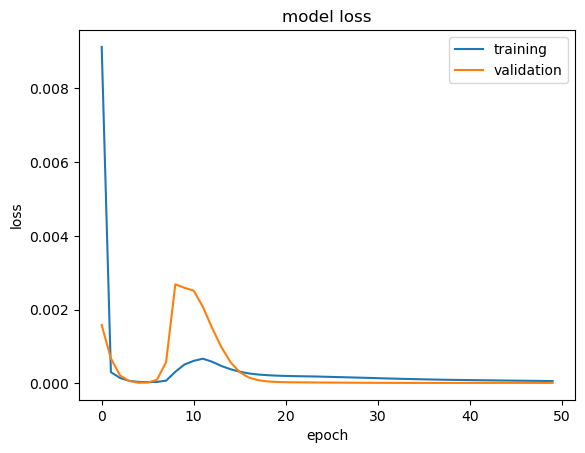

In [15]:
# display training curves
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss')

In [16]:
# make a prediction
y_predict = model.predict(valid_X)

 26/646 [>.............................] - ETA: 2s

2023-01-22 13:29:22.236293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 13:29:22.273599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


646/646 [==============================] - 3s 5ms/step


In [17]:
# invert scaling for forecast
inv_y_predict = scaler.inverse_transform(y_predict)
# invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
inv_y = scaler.inverse_transform(valid_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 84.434


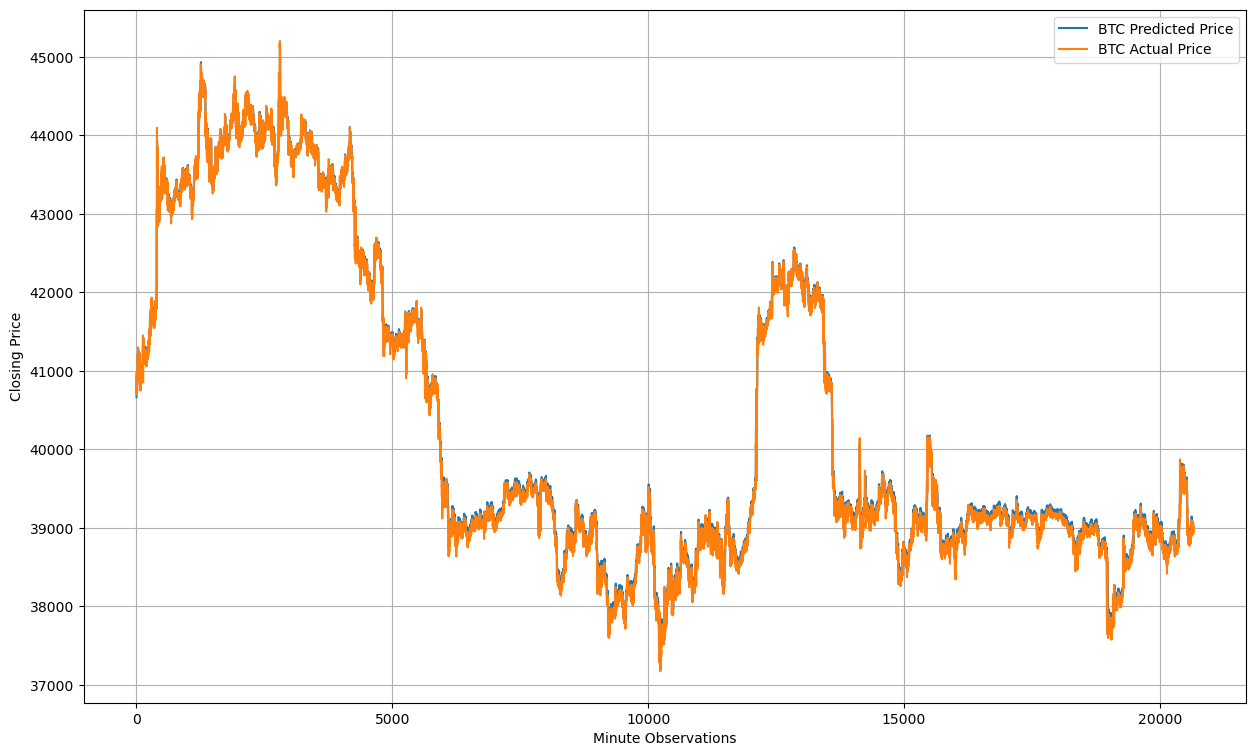

In [18]:
plt.figure(figsize=(15,9))
plt.grid(True)

plt.xlabel('Minute Observations')
plt.ylabel('Closing Price')
plt.plot(inv_y_predict, label='BTC Predicted Price')
plt.plot(inv_y, label='BTC Actual Price')
plt.legend()

In [19]:
# make a prediction
y_test_predict = model.predict(test_X)

646/646 [==============================] - 3s 4ms/step


In [20]:
# invert scaling for forecast
inv_y_test_predict = scaler.inverse_transform(y_test_predict)
# invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
inv_test_y = scaler.inverse_transform(test_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_test_y, inv_y_test_predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 61.178


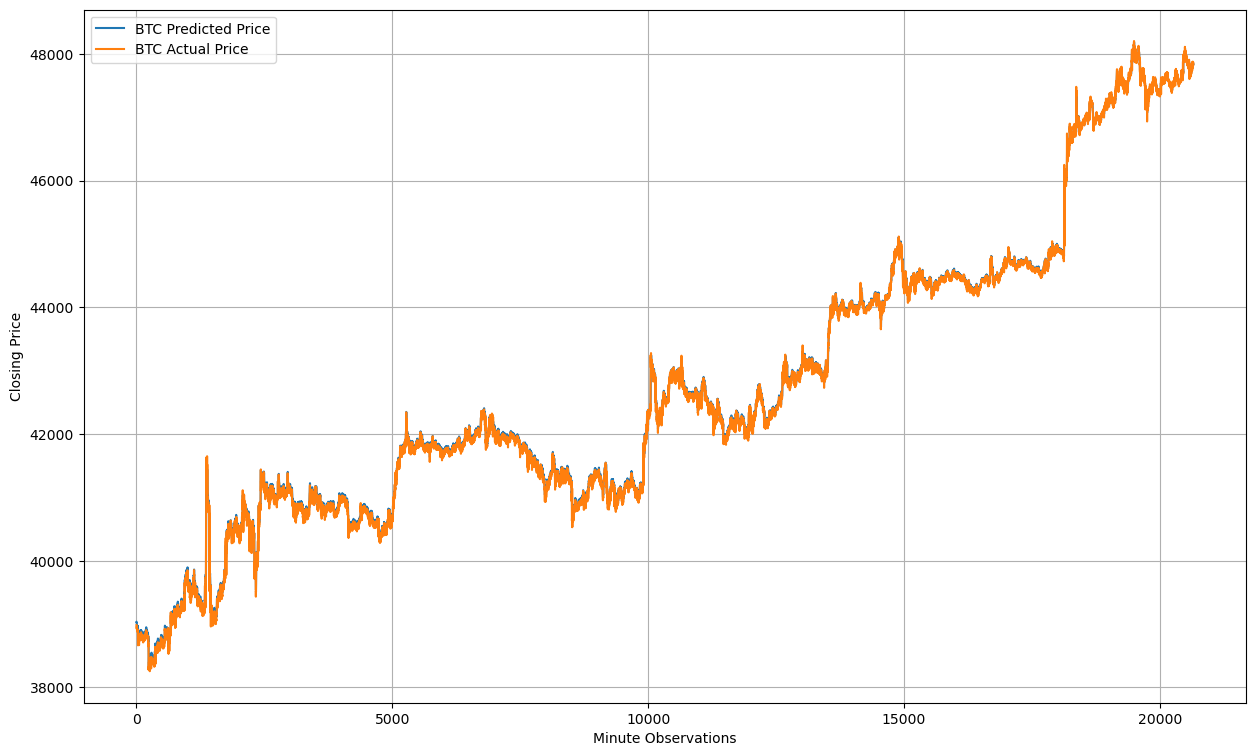

In [21]:
plt.figure(figsize=(15,9))
plt.grid(True)

plt.xlabel('Minute Observations')
plt.ylabel('Closing Price')
plt.plot(inv_y_test_predict, label='BTC Predicted Price')
plt.plot(inv_test_y, label='BTC Actual Price')
plt.legend()